In [1]:
import scanpy as sc
import squidpy as sq
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from collections import Counter
from matplotlib_scalebar.scalebar import ScaleBar
import os

import cell2location
import scvi

DPI=300
FONTSIZE=20 #42
sc.settings.set_figure_params(scanpy = True, dpi=100, transparent=True, vector_friendly = True, dpi_save=DPI) 
from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42

from matplotlib import rcParams
import seaborn as sns
from pathlib import Path

# QC utils functions - a package 
from vistools import utils
from vistools import spatial_plots

Global seed set to 0


In [2]:
SAMPLE_NAME = 'Valdeolivas_2023_SN048_A416371_Rep1'

In [3]:
# visium data path
SP_DATA_DIR = Path(
    f'/data/BCI-CRC/nasrine/data/CRC/spatial/public/Visium_Valdeolivas_2023/raw/SN048_A416371_Rep1') 

In [4]:
# store results 
DIR2SAVE = Path(f'/data/BCI-CRC/nasrine/data/CRC/spatial/public/Visium_Valdeolivas_2023/qc/{SAMPLE_NAME}') # to change
DIR2SAVE.mkdir(parents=True, exist_ok=True)

In [5]:
# figures
FIG2SAVE = DIR2SAVE.joinpath('figures/')
FIG2SAVE.mkdir(parents=True, exist_ok=True)
# set the global variable: sc.settings.figdir to save all plots 
sc.settings.figdir = FIG2SAVE

---
### 1. Load Visium data 

In [6]:
adata_vis = utils.read_and_qc(SP_DATA_DIR
                             )

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Sample  Count_SN048_A416371_Rep1


In [8]:
# create new column in case of plotting maybe ?
adata_vis.obs["Sample_source"] = SAMPLE_NAME + "-" + adata_vis.obs.Sample

In [9]:
# check no gene name duplicates since we used unique
# get gene names Couter style
#Counter(np.array(adata_sc.var_names))
Counter(np.array(adata_vis.var.index))
print([k for k, v in Counter(np.array(adata_vis.var.index)).items() if v > 1])

[]


In [11]:
adata_vis.obs.describe()

in_tissue    array_row    array_col  n_genes_by_counts  total_counts  \
count     2317.0  2317.000000  2317.000000        2317.000000   2317.000000   
mean         1.0    39.738886    58.239534        4106.423392  11499.082031   
std          0.0    14.394081    27.857614        1720.112176   7578.946777   
min          1.0    11.000000     3.000000          59.000000     59.000000   
25%          1.0    29.000000    36.000000        2816.000000   5455.000000   
50%          1.0    40.000000    59.000000        4116.000000   9924.000000   
75%          1.0    51.000000    81.000000        5525.000000  16568.000000   
max          1.0    68.000000   115.000000        8118.000000  39115.000000   

       pct_counts_in_top_50_genes  pct_counts_in_top_100_genes  \
count                 2317.000000                  2317.000000   
mean                    17.763944                    26.537801   
std                      2.672657                     4.104829   
min                     13.390929                    20.086393   
25%                     16.727407                    24.998627   
50%                     17.560750                    26.195029   
75%                     18.458781                    27.467286   
max                     84.745763                   100.000000   

       pct_counts_in_top_200_genes  pct_counts_in_top_500_genes  \
count                  2317.000000                  2317.000000   
mean                     36.668625                    51.777071   
std                       5.165544                     6.819270   
min                      28.630306                    43.027888   
25%                      34.739665                    48.690892   
50%                      36.119403                    50.442584   
75%                      37.575758                    52.488849   
max                     100.000000                   100.000000   

       total_counts_mt  pct_counts_mt  total_counts_ribo  pct_counts_ribo  
count      2317.000000    2317.000000        2317.000000      2317.000000  
mean         74.620628       0.808485        1875.364746        15.796888  
std          63.600842       0.615648        1338.218262         2.213577  
min           0.000000       0.000000           8.000000         7.633588  
25%          38.000000       0.370515         809.000000        14.277181  
50%          59.000000       0.565448        1553.000000        15.597454  
75%          86.000000       1.012312        2701.000000        17.190237  
max         482.000000       4.019670        7312.000000        23.949219

In [12]:
adata_vis.var.describe()

n_cells_by_counts   mean_counts  pct_dropout_by_counts   total_counts
count       36601.000000  36601.000000           36601.000000   36601.000000
mean          259.954182      0.314174              88.780570     727.941101
std           468.556021      1.918701              20.222530    4445.630859
min             0.000000      0.000000               0.172637       0.000000
25%             0.000000      0.000000              85.066897       0.000000
50%             5.000000      0.002158              99.784204       5.000000
75%           346.000000      0.170047             100.000000     394.000000
max          2313.000000    134.120850             100.000000  310758.000000

In [13]:
# remove MT genes for spatial mapping (keeping their counts in the object)
print('Number of mt genes:', adata_vis.var['mt'].sum())
adata_vis.obsm['mt'] = adata_vis[:, adata_vis.var['mt'].values].X.toarray()
adata_vis = adata_vis[:, ~adata_vis.var['mt'].values] 
print('After mt genes removal ', adata_vis.shape)

Number of mt genes: 13
After mt genes removal  (2317, 36588)


In [14]:
# remove ribosomal genes as well as we remove them from the scRNA-seq data when we do the analysis
print('Number of ribo genes:', adata_vis.var['ribo'].sum())
adata_vis.obsm['ribo'] = adata_vis[:, adata_vis.var['ribo'].values].X.toarray()
adata_vis = adata_vis[:, ~adata_vis.var['ribo'].values].copy() 
print("After ribo genes removal ", adata_vis.shape)

Number of ribo genes: 103
After ribo genes removal  (2317, 36485)


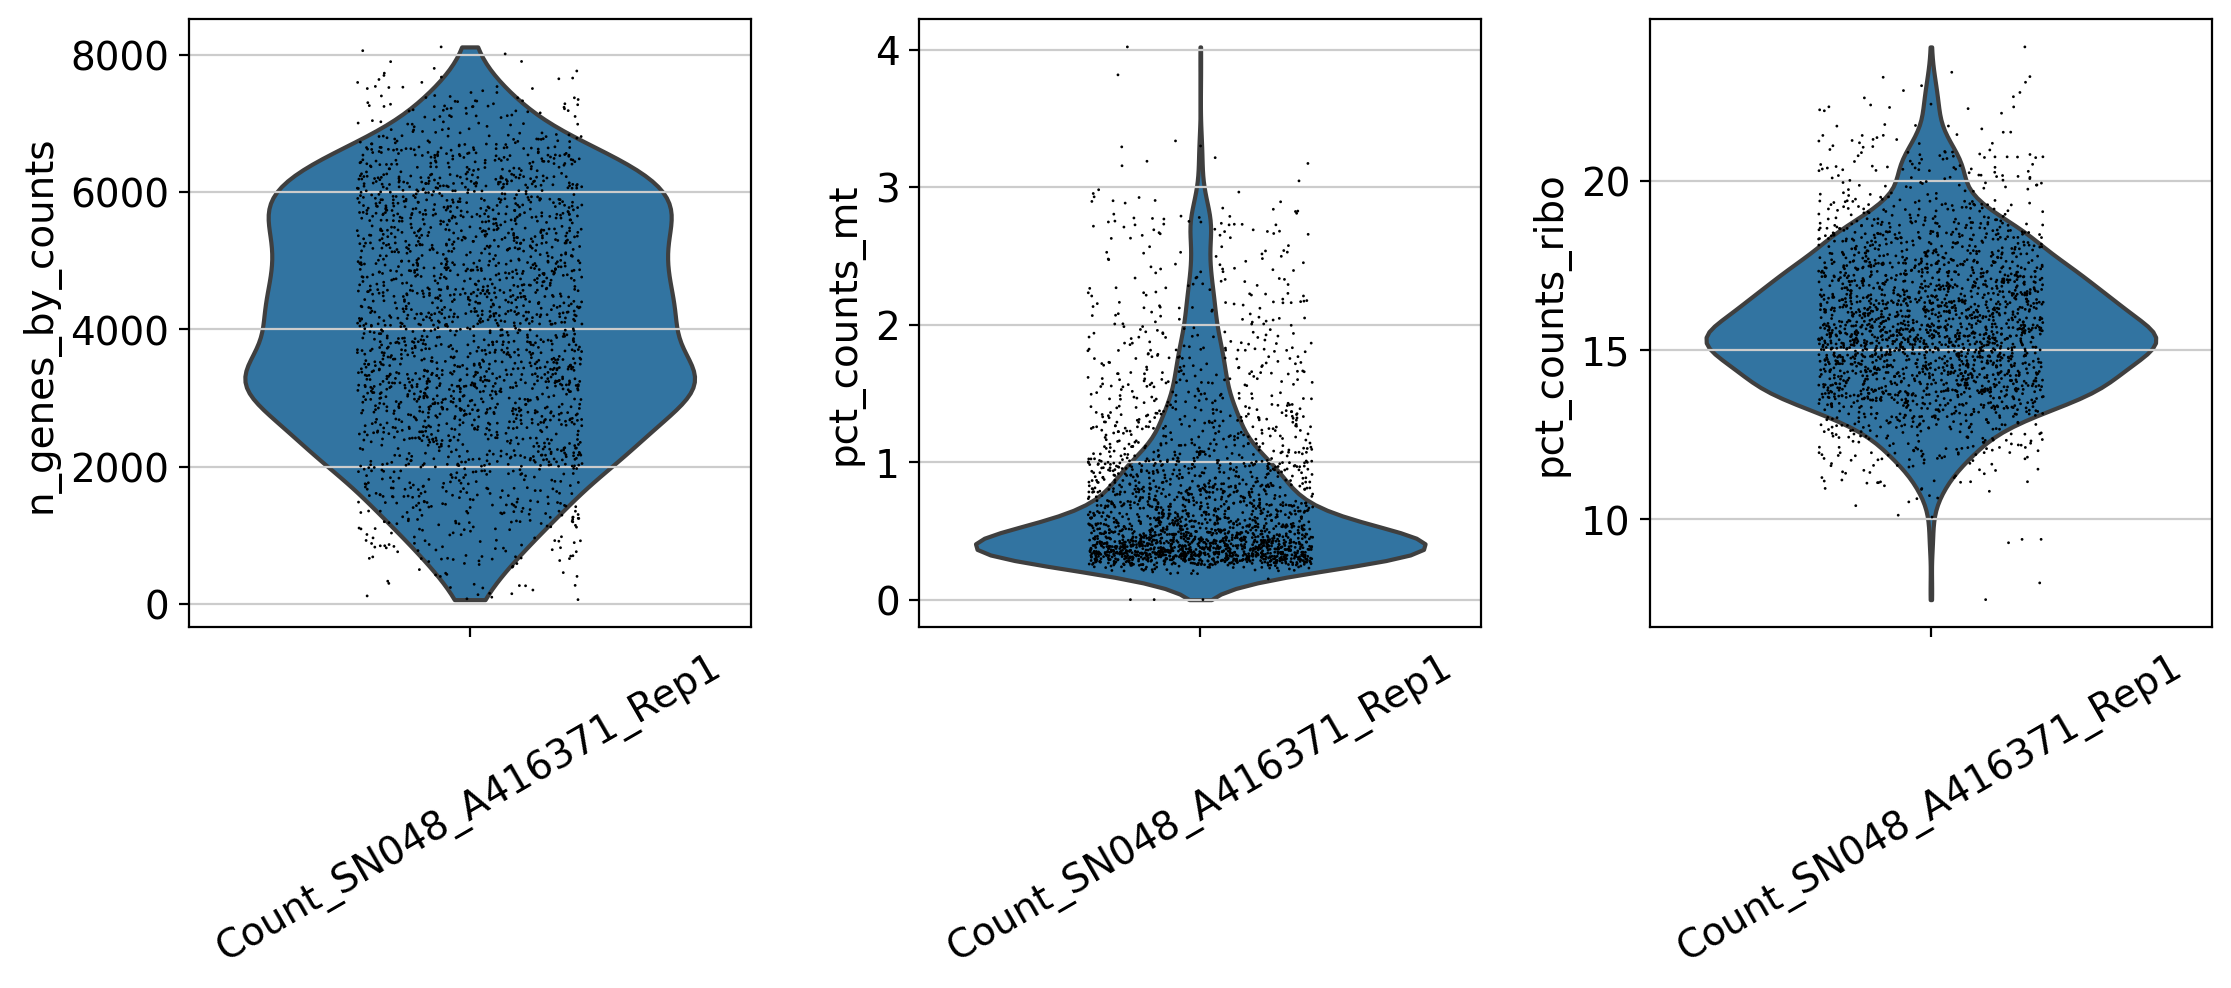

In [15]:
# violin plot of some distributions 
sc.pl.violin(adata_vis, keys=['n_genes_by_counts', 'pct_counts_mt', 'pct_counts_ribo'], groupby='Sample',
             jitter=0.2, multi_panel=True, rotation=30, show=True, save='QC_covariates.pdf')

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


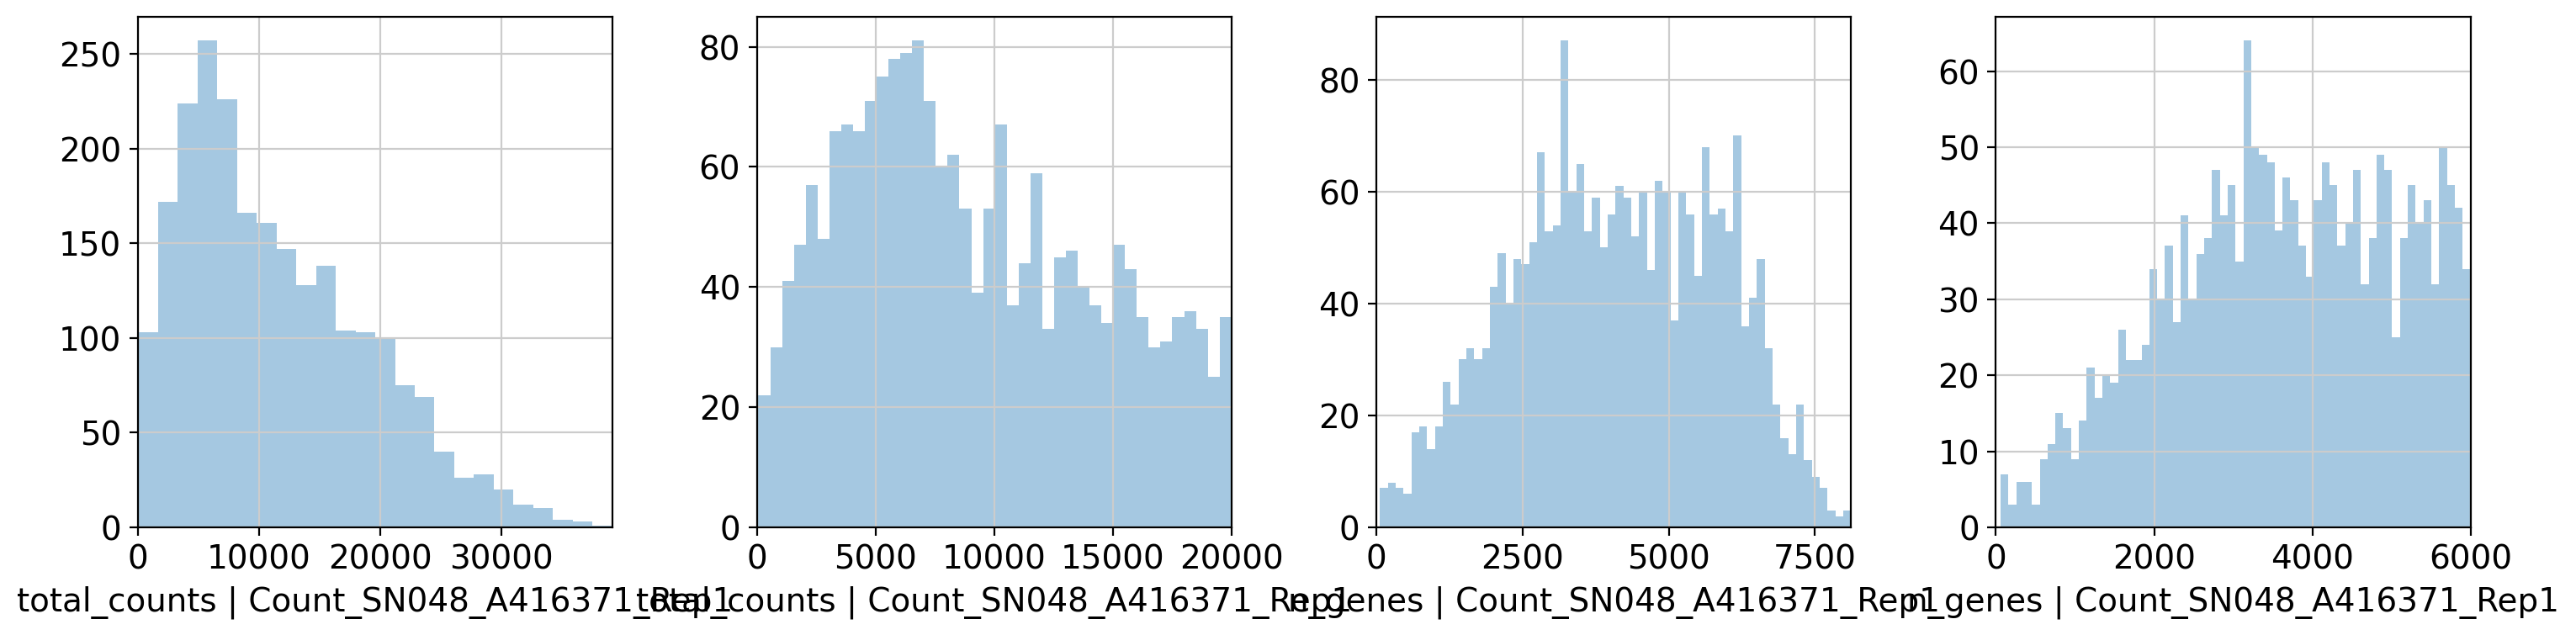

In [16]:
fig, axs = plt.subplots(1, 4, figsize=(15, 4))
axs = axs.reshape((1, 4))

#fig.suptitle('Covariates for filtering')
    
sns.distplot(adata_vis.obs['total_counts'], 
             kde=False, ax = axs[0, 0])
axs[0, 0].set_xlim(0, adata_vis.obs['total_counts'].max())
axs[0, 0].set_xlabel('total_counts | ' + adata_vis.obs["Sample"].cat.categories[0])
    
sns.distplot(adata_vis.obs['total_counts']\
             [adata_vis.obs['total_counts']<20000],
             kde=False, bins=40, ax = axs[0, 1])
axs[0, 1].set_xlim(0, 20000)
axs[0, 1].set_xlabel('total_counts | ' + adata_vis.obs["Sample"].cat.categories[0])
    
sns.distplot(adata_vis.obs['n_genes_by_counts'],
             kde=False, bins=60, ax = axs[0, 2])
axs[0, 2].set_xlim(0, adata_vis.obs['n_genes_by_counts'].max())
axs[0, 2].set_xlabel('n_genes | ' + adata_vis.obs["Sample"].cat.categories[0])
    
sns.distplot(adata_vis.obs['n_genes_by_counts']\
             [adata_vis.obs['n_genes_by_counts']<6000],
             kde=False, bins=60, ax = axs[0, 3])
axs[0, 3].set_xlim(0, 6000)
axs[0, 3].set_xlabel('n_genes | ' + adata_vis.obs["Sample"].cat.categories[0])
    
plt.tight_layout()
plt.savefig(FIG2SAVE.joinpath('hist_QC_covariates.pdf'), dpi=DPI, format='pdf', bbox_inches='tight')
plt.show()

In [17]:
# filtering visium data
sc.pp.filter_cells(adata_vis, min_genes=5)
sc.pp.filter_genes(adata_vis, min_cells=3) #10

In [18]:
adata_vis.shape

(2317, 19382)

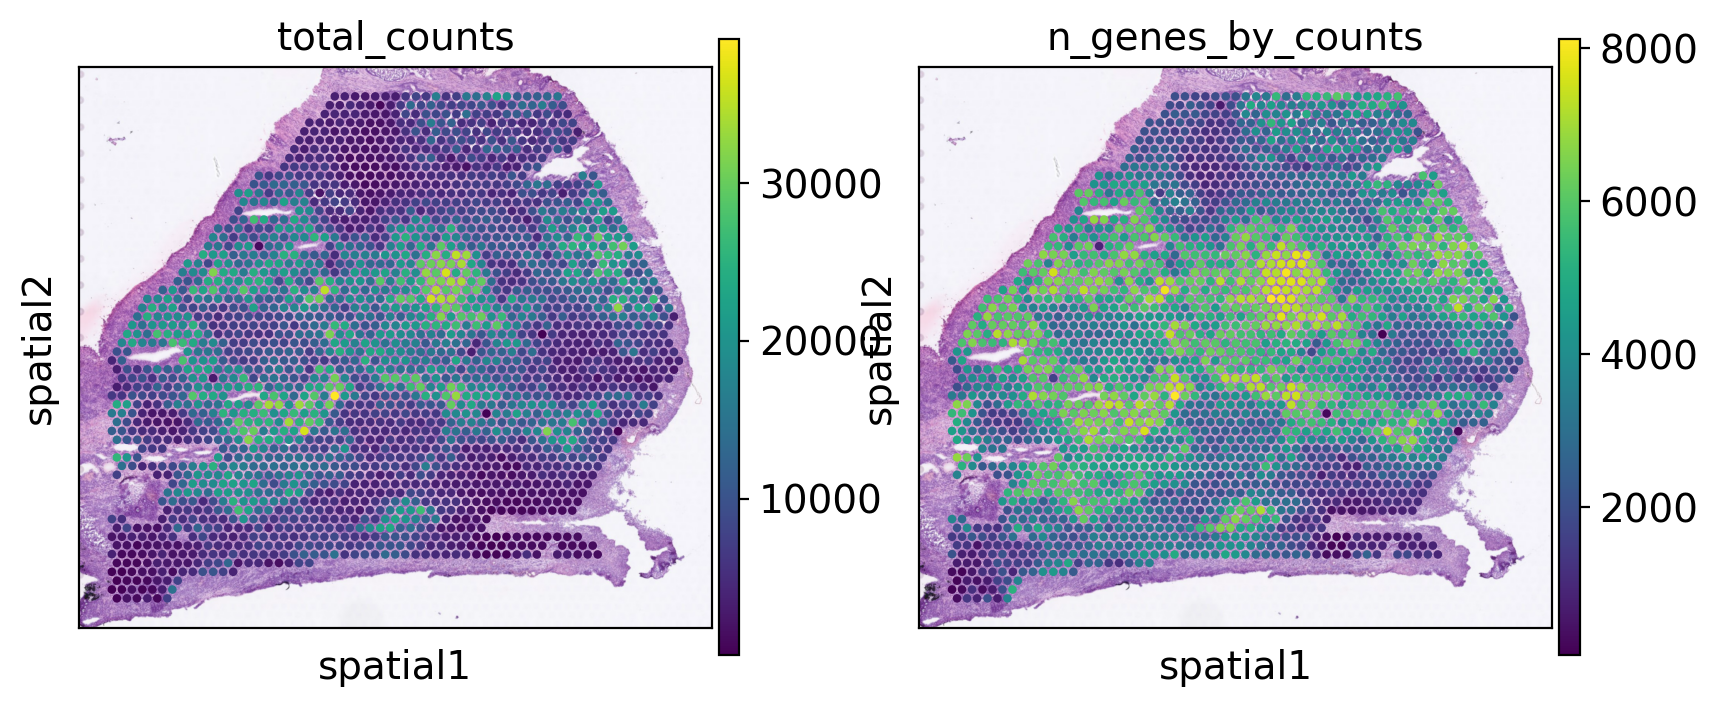

In [19]:
sc.pl.spatial(adata_vis, img_key = "hires", cmap='viridis',
              color=['total_counts', 'n_genes_by_counts'],
              gene_symbols='SYMBOL', size=1.3, save='QC_covariates.pdf')

### segmentation
---

In [20]:
adata_vis.obs.Sample.cat.categories.values[0]

'Count_SN048_A416371_Rep1'

In [21]:
# scale factor
adata_vis.uns['spatial'][adata_vis.obs.Sample.cat.categories.values[0]]['scalefactors']['tissue_hires_scalef']

0.9302326

In [22]:
my_image = sq.im.ImageContainer(img=adata_vis.uns['spatial'][adata_vis.obs.Sample.cat.categories.values[0]]['images']['hires'], 
                                layer="image",
                                scale=adata_vis.uns['spatial'][adata_vis.obs.Sample.cat.categories.values[0]]['scalefactors']['tissue_hires_scalef']
                               )

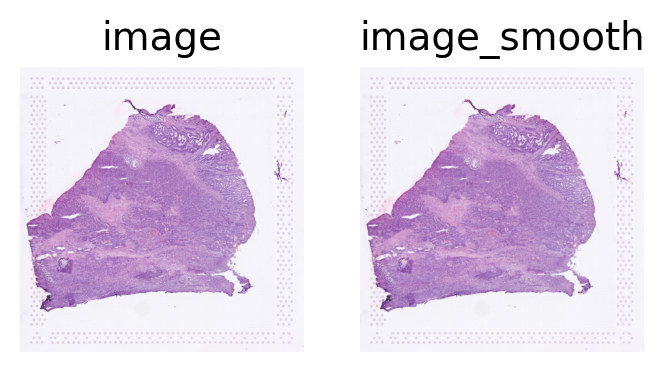

In [23]:
# Before segmenting the image, we smooth it using squidpy.im.process().
sq.im.process(img=my_image, layer="image", method="smooth")
# plot the result
fig, axes = plt.subplots(1, 2)
for layer, ax in zip(["image", "image_smooth"], axes):
    my_image.show(layer, ax=ax)
    ax.set_title(layer)

#### segment
We will use channel 0 to do the segmentation, as this channel contains most of the nuclei information within an H&E stain.

We use squidpy.im.segment() with method = 'watershed' to do the segmentation. Since, opposite to the fluorescence DAPI stain, in the H&E stain nuclei appear darker, we need to indicate to the model that it should treat lower-intensity values as foreground. We do this by specifying the geq = False in the kwargs.

In [24]:
sq.im.segment(img=my_image, 
              layer="image_smooth", 
              layer_added="segmented_watershed", 
              method="watershed", 
              channel=0,
              qeq=False
             )

In [25]:
my_image

ImageContainer[shape=(2000, 1988), layers=['image', 'image_smooth', 'segmented_watershed']]

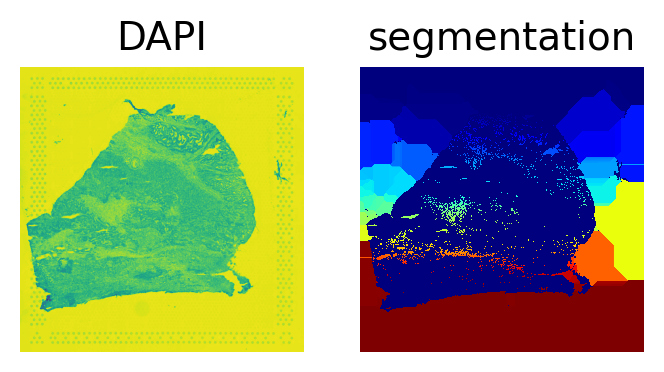

In [26]:
fig, axes = plt.subplots(1, 2)
my_image.show("image", channel=0, ax=axes[0])
_ = axes[0].set_title("DAPI")
my_image.show("segmented_watershed", cmap="jet", interpolation="none", ax=axes[1])
_ = axes[1].set_title("segmentation")

We then need to extract some image features from the tissue underneath each spot, useful for the deconvolution task downstream. Specifically, we will need:

   * the number of unique segmentation objects (i.e. nuclei) under each spot.

   *  the coordinates of the centroids of the segmentation object.

It will become clear later how we will be using them.

Now we can calculate segmentation features. Here, we will calculate the following features:

* number of nuclei `label`
* mean area of nuclei `area`

We use `mask_cicle = True` to ensure that we are only extracting features from the tissue underneath each Visium spot. 

In [27]:
sq.im.calculate_image_features(
    adata_vis,
    my_image,
    layer='image',#"image",
    features="segmentation",
    key_added="segmentation_features",
    features_kwargs={
        "segmentation": {
            "label_layer": "segmented_watershed",
            "props": ["label", "area", "mean_intensity"],
            "channels": [1, 2],
        }
    },
    mask_circle=True,
)

  0%|          | 0/2317 [00:00<?, ?/s]

/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scala

In [29]:
adata_vis.obsm["segmentation_features"]['segmentation_label'].value_counts()

0     1363
1      357
2      217
3      156
4       98
5       61
6       44
7       11
8        8
9        1
10       1
Name: segmentation_label, dtype: int64

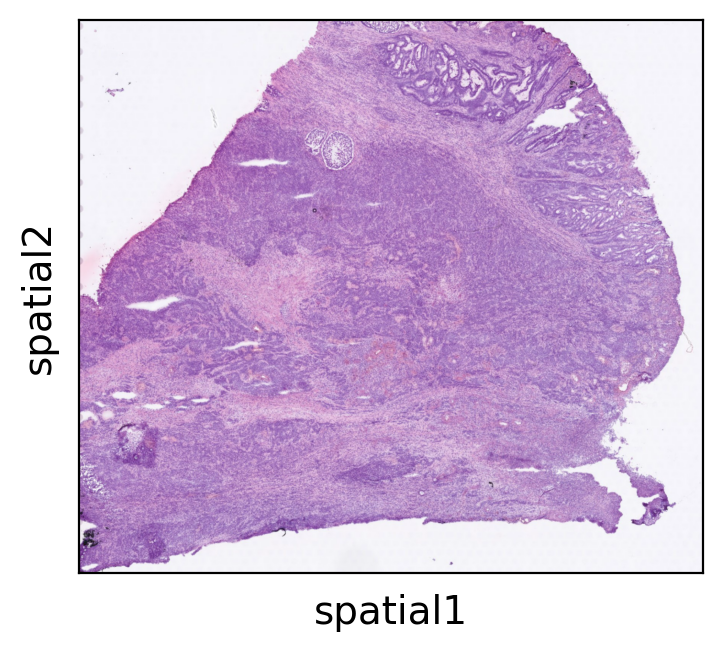

In [30]:
sc.pl.spatial(adata_vis, img_key = "hires", save="HEstain.pdf", show=True)

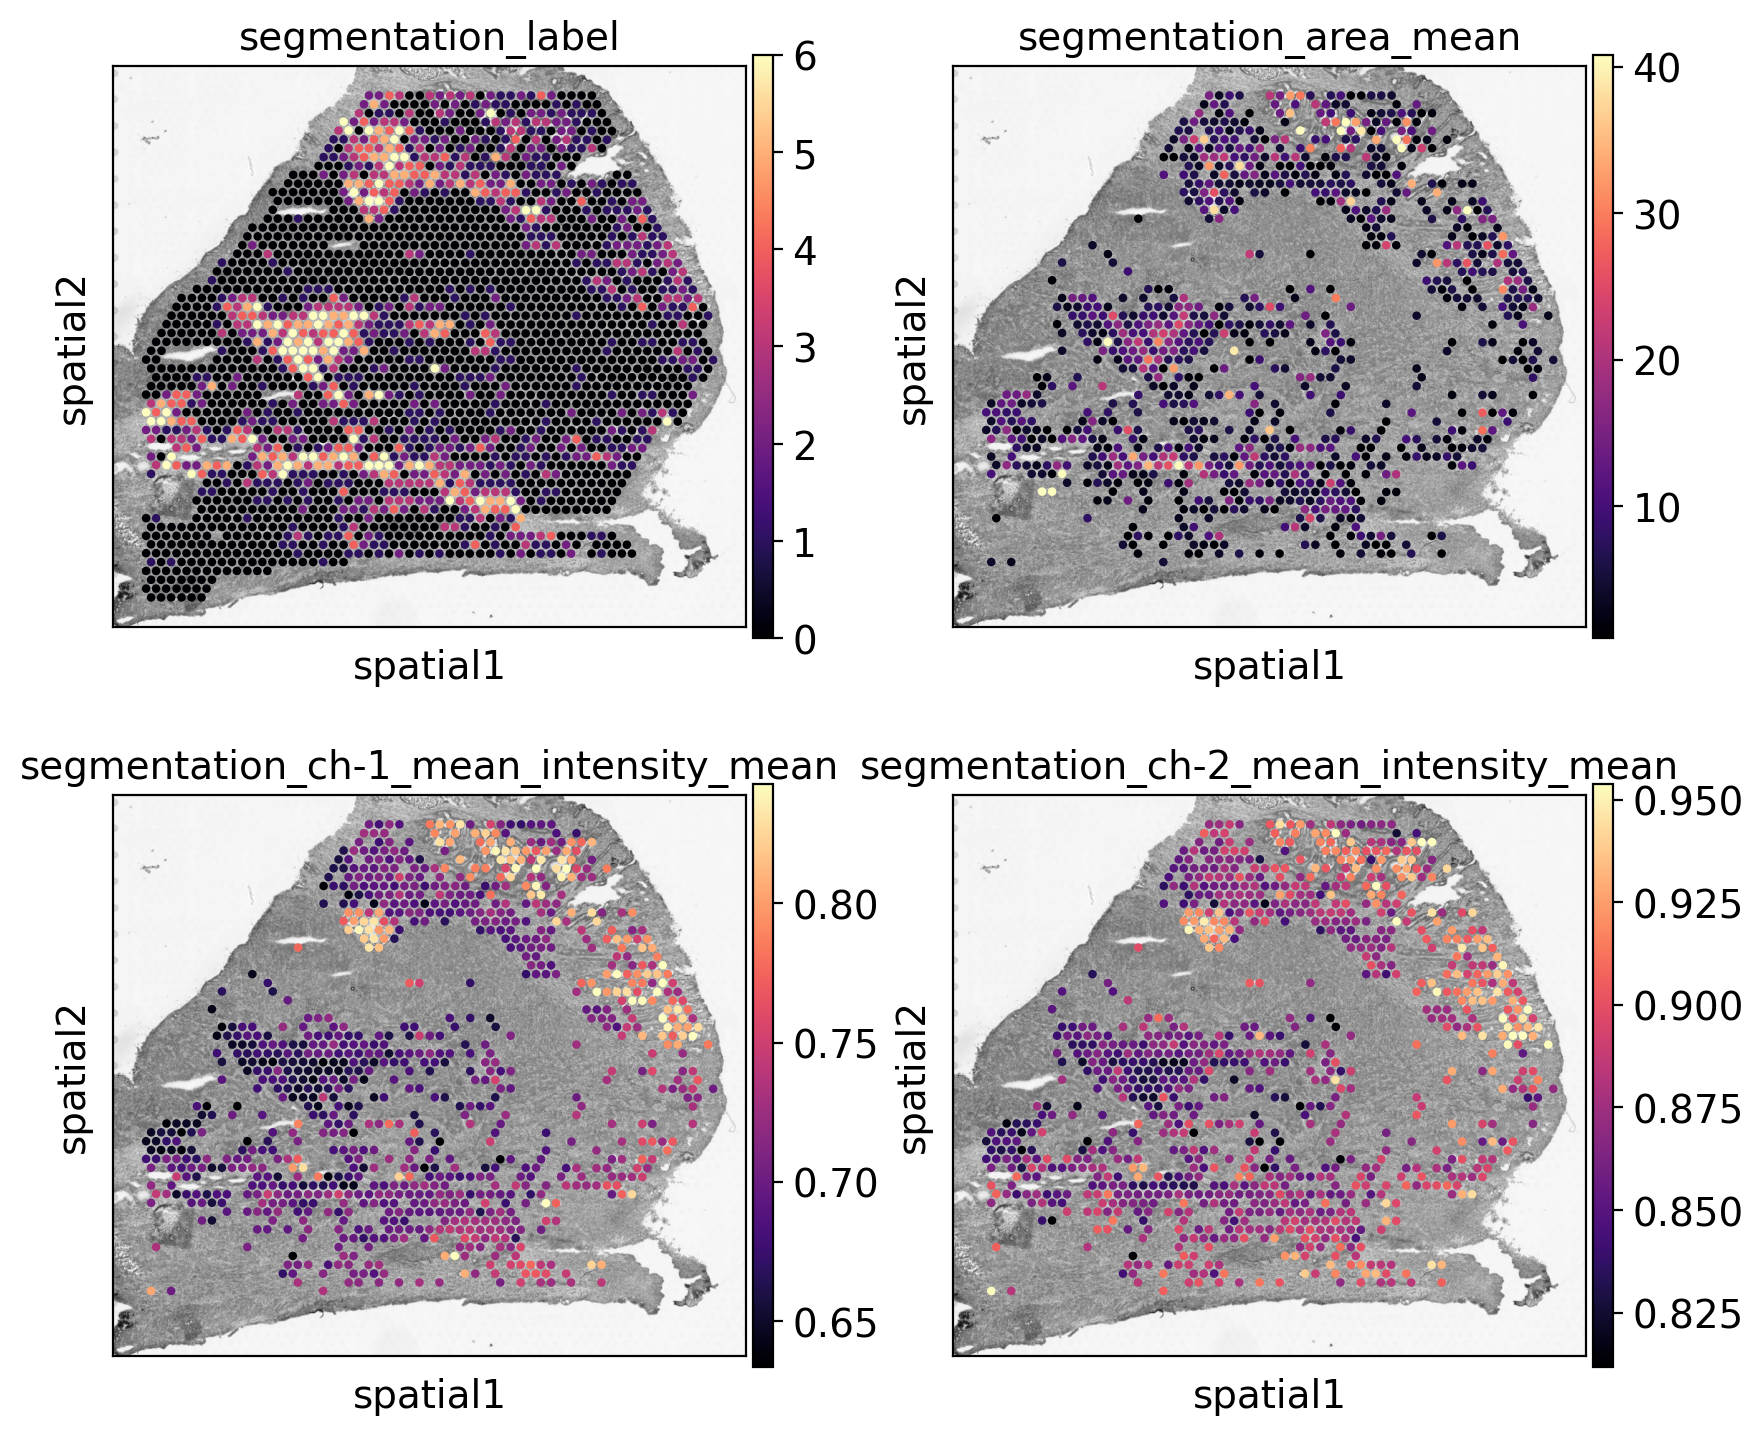

In [32]:
# plot segmentation features
sc.pl.spatial(
    sq.pl.extract(adata_vis, "segmentation_features"),
    color=[
        "segmentation_label",
        "segmentation_area_mean",
        "segmentation_ch-1_mean_intensity_mean",
        "segmentation_ch-2_mean_intensity_mean",
    ],
    bw=True,
    ncols=2,
    vmin="p1",
    vmax="p99",
    size=1.3,
    cmap="magma"
)

In [33]:
adata_vis.obsm["segmentation_features"]['segmentation_label'].mean()

1.027190332326284

In [34]:
adata_vis.obsm["segmentation_features"]['segmentation_label'].describe()

count    2317.000000
mean        1.027190
std         1.622021
min         0.000000
25%         0.000000
50%         0.000000
75%         2.000000
max        10.000000
Name: segmentation_label, dtype: float64

### read pathology annotations

In [35]:
patho_annot = pd.read_csv("/data/BCI-CRC/nasrine/data/CRC/spatial/public/Visium_Valdeolivas_2023/Pathology_SpotAnnotations/Pathologist_Annotations_SN048_A416371_Rep1.csv",
                         index_col=0)

In [38]:
patho_annot.index = "Count_SN048_A416371_Rep1_" + patho_annot.index

In [40]:
adata_vis.obs = adata_vis.obs.merge(patho_annot,
                    how='left',
                    left_index=True,
                    right_index=True
                   )

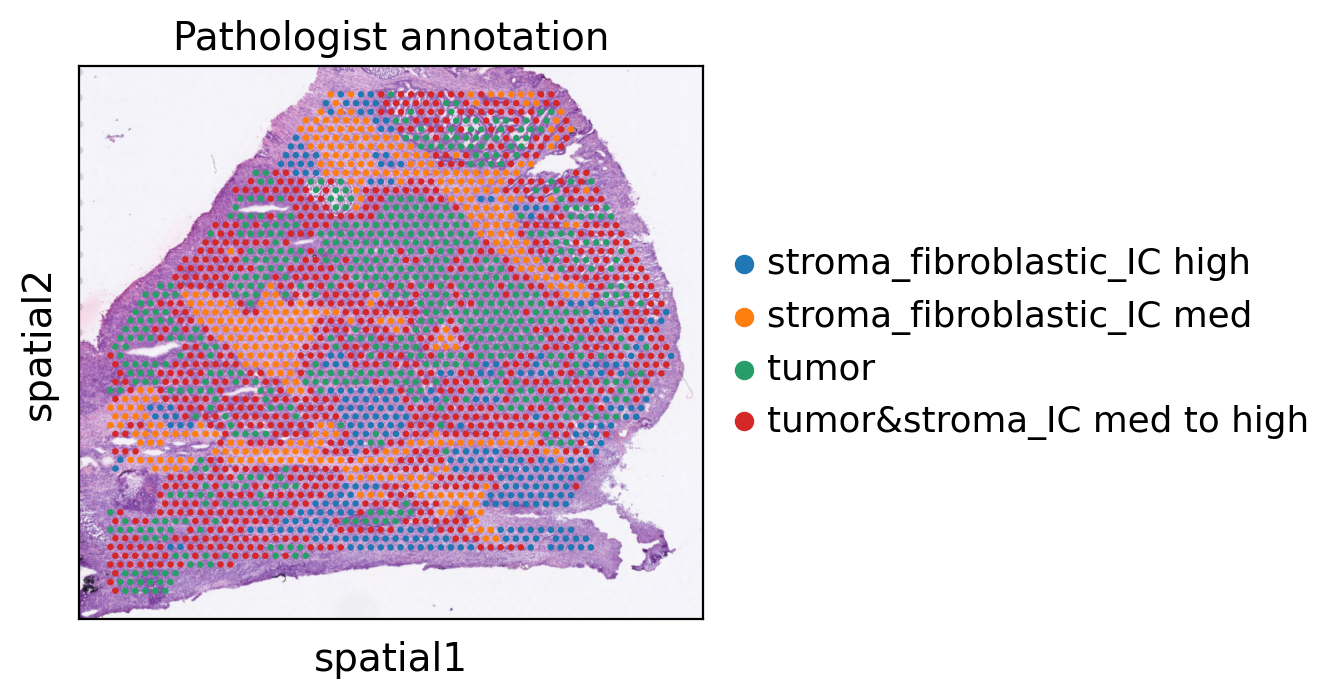

In [42]:
sc.pl.spatial(adata_vis, color="Pathologist annotation", save="Pathologist_annotations.pdf")

### save raw filtered counts

In [43]:
adata_vis.write(DIR2SAVE.joinpath(f"{SAMPLE_NAME}_raw.h5ad"))